# Fusion de données avec PolaBot #

Dans ce notebook, je vais essayer d'entraîner un réseau ResNet50 sur Polabot afin de comparer les performances de classification sur des images polarimétriques et sur des images qui ne le sont pas. 

Avant toute chose, je vais modifier les étiquettes des images de Polabot, car leur vérité terrain consiste à délimiter les zones des différents "matériaux" des images (se référer au Notebook présentant la BD pour mieux comprendre sa composition). Je vais donc étiqueter les images en qui contiennent au moins une voiture avec 0 et celles qui ne contiennent aucune voiture avec 1.

Suite à cela, je vais entraîner le réseau ResNet50 sur les images RGB classiques et je vais entraîner un autre réseau ResNet50 sur les images polarimétriques. Je vais comparer les performances de ces deux réseaux et enfin, je vais entraîner un réseau ResNet50 qui prend en entrée et une image RGB et une image polarimétrique afin de voir si la fusion de ces deux types d'images permet d'avoir une meilleure performance que les deux réseaux précédents.

In [1]:
# Etiquetage des données

import os
import imageio
import pylab as pl

# Définition des chemins
path = "/Users/rblin/Downloads/PolaBot-Dataset"
dossiers = os.listdir(path)
path_BGR = path + "/" + dossiers[1]
path_polar = path + "/" + dossiers[5]

# Liste de éléments
dossiers = os.listdir(path)
elements_BGR = sorted(os.listdir(path_BGR))
elements_polar = sorted(os.listdir(path_polar))

# Retirer les éléments qui ne sont pas des images
elements_BGR.remove("output")
elements_BGR.remove(".DS_Store")
elements_polar.remove(".DS_Store")

# Affichage d'un élément de la ground truth contenant 
# une voiture, afin de connaître la valeur des pixels 
# qui caractérisent la voiture dans la colormap

path_gt = path + "/" + dossiers[3] 
path_gt_car = path_gt + "/Colorized_GroundTruth/1.png"
im = imageio.imread(path_gt_car)
pl.figure(1)
pl.imshow(im)
pl.title("Ground truth contenant une voiture")

Text(0.5, 1.0, 'Ground truth contenant une voiture')

Format image BGR :  (190, 254, 3)
Format image polar :  (460, 640)


<Figure size 432x288 with 0 Axes>

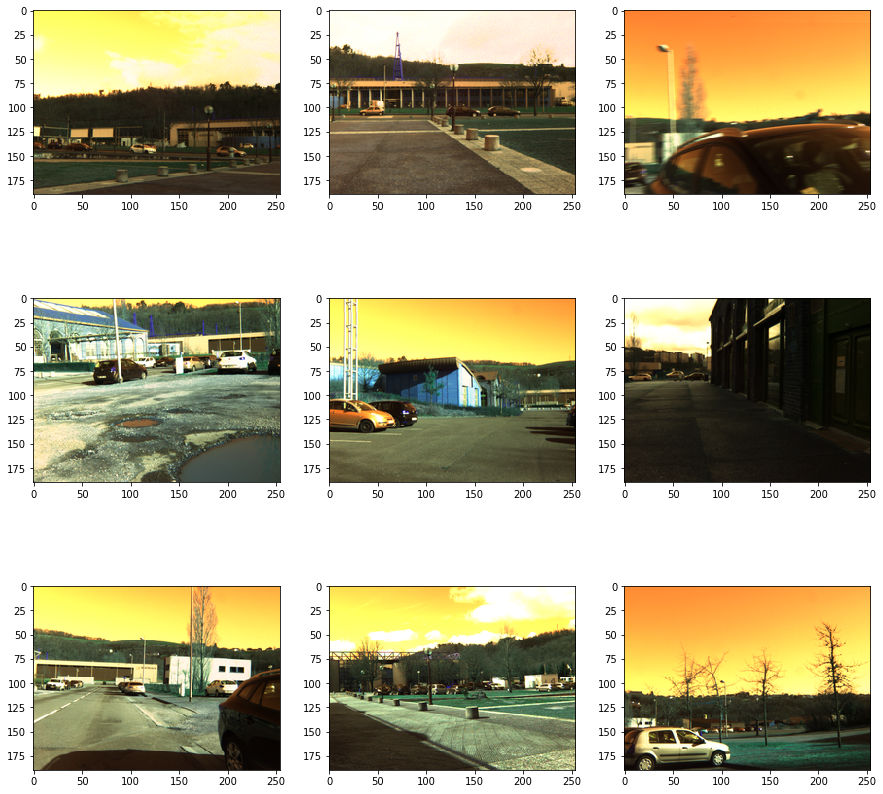

In [2]:
# On voit qu'il y a d'autres pixels de la même couleur
# dans l'image ne représentant pas une voiture du coup
# il faudra étiqueter les images à la main

import numpy as np
import random

Y = np.zeros((177,1))
Y = Y.astype(int)

# Indices des images ne contenant pas de voiture 

ind = [19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 39, 40, 41, 42, 43, 44, 46, 47, 51, 54, 55, 56, 59, 62, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 109, 114, 115, 119, 120, 129, 133, 148, 149, 153, 164, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176]

Y[ind] = 1

# Il faut maintenant diviser les images en ensembles
# d'apprentissage et de test

indexes_train = random.sample(range(0,176),89)
indexes_test = [i for i in range(177)]
for j in indexes_train :
    indexes_test.remove(j)

Y_train = Y[indexes_train]
Y_test = Y[indexes_test]

list_img_BGR_train = []
list_img_polar_train = []
for k in indexes_train :
    list_img_BGR_train.append(elements_BGR[k])
    list_img_polar_train.append(elements_polar[k])

list_img_BGR_test = []
list_img_polar_test = []
for l in indexes_test :
    list_img_BGR_test.append(elements_BGR[l])
    list_img_polar_test.append(elements_polar[l])
    
# Regardons maintenant le format des images BGR et polar 
im_BGR = imageio.imread(path_BGR + "/" + list_img_BGR_train[0])
print("Format image BGR : ", im_BGR.shape)
im_polar = imageio.imread(path_polar + "/" + list_img_polar_train[0])
print("Format image polar : ", im_polar.shape)

# Maintenant qu'on a le format, on va constituer les vecteurs
# qui vont contenir les images pour l'apprentissage du réseau

X_train_BGR = np.zeros((89, 190, 254, 3))
X_train_BGR = X_train_BGR.astype(int)

X_train_polar = np.zeros((89, 460, 640))
X_train_polar = X_train_polar.astype(int)

X_test_BGR = np.zeros((88, 190, 254, 3))
X_test_BGR = X_test_BGR.astype(int)

X_test_polar = np.zeros((88, 460, 640))
X_test_polar = X_test_polar.astype(int)

# Images de train
for m in range(len(list_img_BGR_train)) :
    im_BGR_temp = imageio.imread(path_BGR + "/" + list_img_BGR_train[m])
    im_BGR_np_temp = np.asarray(im_BGR_temp)
    im_polar_temp = imageio.imread(path_polar + "/" + list_img_polar_train[m])
    im_polar_np_temp = np.asarray(im_polar_temp)
    X_train_BGR[m, :, :, :] = im_BGR_np_temp
    X_train_polar[m, :, :] = im_polar_np_temp
    
for n in range(len(list_img_BGR_test)) :
    im_BGR_temp = imageio.imread(path_BGR + "/" + list_img_BGR_test[n])
    im_BGR_np_temp = np.asarray(im_BGR_temp)
    im_polar_temp = imageio.imread(path_polar + "/" + list_img_polar_test[n])
    im_polar_np_temp = np.asarray(im_polar_temp)
    X_test_BGR[n, :, :, :] = im_BGR_np_temp
    X_test_polar[n, :, :] = im_polar_np_temp
    
# Affichage de 9 images au hasard contenant une voiture
# afin de vérifier que l'étiquetage a été fait correctement

itemindex = np.where(Y_train==0)

indexes = itemindex[0]
indexes = indexes.tolist()

rand_ind = random.sample(indexes, 9)

pl.figure(2)
pl.figure(figsize=(15,15))
pl.clf()
for i in range(9) :
    pl.subplot(3,3,i+1)
    im_temp = X_train_BGR[rand_ind[i]]
    pl.imshow(im_temp)



<Figure size 432x288 with 0 Axes>

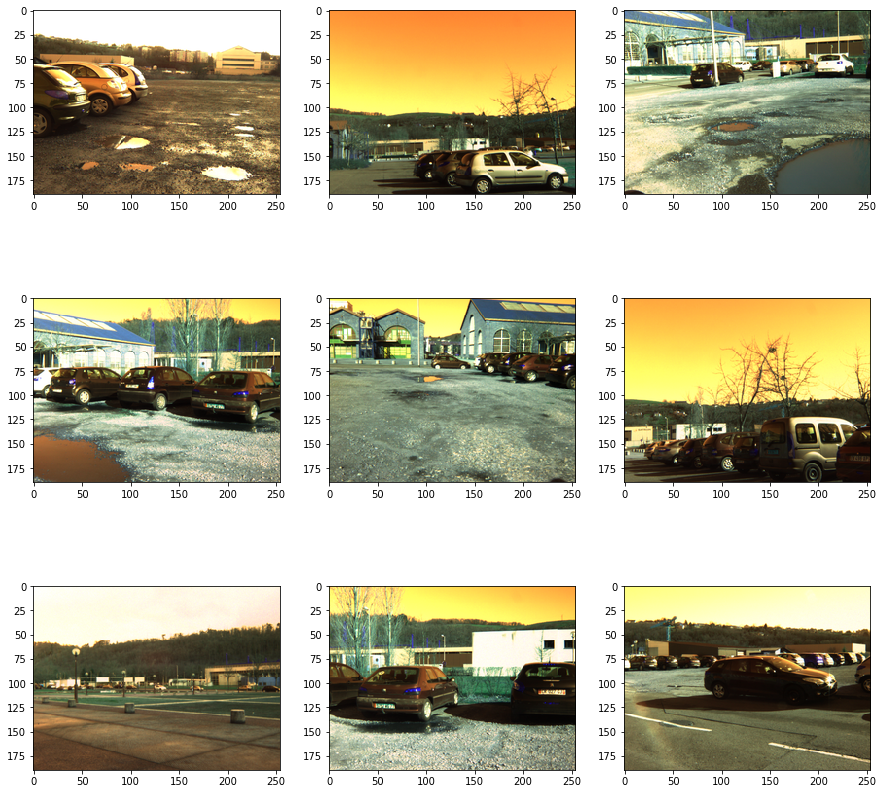

In [3]:
# De même pour les images de test

itemindex = np.where(Y_test==0)

indexes = itemindex[0]
indexes = indexes.tolist()

rand_ind = random.sample(indexes, 9)

pl.figure(3)
pl.figure(figsize=(15,15))
pl.clf()
for i in range(9) :
    pl.subplot(3,3,i+1)
    im_temp = X_test_BGR[rand_ind[i]]
    pl.imshow(im_temp)

In [4]:
# On a maintenant les vecteurs prets pour l'apprentissage,
# mettons donc en place le réseau de neurones 

import keras
from keras.applications.resnet50 import ResNet50


model = ResNet50(weights='imagenet', include_top=False)

Using TensorFlow backend.
/Users/rblin/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
#model.summary()

from keras.engine.input_layer import Input
from keras.layers import Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

num_classes =2
print(model.input)

input = Input(shape = (190, 254, 3))

x = Flatten()(model(input))
x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='linear')(x)

new_model = Model(inputs=input, outputs=x)

new_model.summary()

# Puisque l'on a 89 images de train et de test, il est nécessaire
# d'avoir plus de données pour pouvoir effectuer un apprentissage
# pertinent. Pour cela, on va utiliser des techniques de data 
# augmentation. 

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 190, 254, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              98305000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)      

In [6]:
# Maintenant que le modèle a été construit pour les 
# images RGB, on peut passer à l'entraînement 

from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

epochs = 1
batch_size = 16

new_model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

#print(X_test_BGR.shape)
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

#datagen.fit(X_train_BGR)

print(type(X_test_BGR), type(Y_test))

new_model.fit_generator(datagen.flow(X_train_BGR, Y_train,
          batch_size=batch_size),
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_BGR, Y_test))
score = new_model.evaluate(X_test_BGR, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/1
6/6 [==============================] - 275s 46s/step - loss: 5.5418 - acc: 0.5229 - val_loss: 8.2422 - val_acc: 0.4886
Test loss: 8.242208047346635
Test accuracy: 0.48863636634566565


In [ ]:
# Construisons maintenant un modèle pour les images polarimétriques 

import keras
from keras.applications.resnet50 import ResNet50
from keras.engine.input_layer import Input
from keras.layers import Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model

model = ResNet50(weights='imagenet', include_top=False)

num_classes =2
print(model.input)

input = Input(shape = (460, 640, 1))

x = Flatten()(model(input))
x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='linear')(x)

new_model = Model(inputs=input, outputs=x)

new_model.summary()

In [ ]:
# Maintenant que le modèle a été construit pour les 
# images RGB, on peut passer à l'entraînement 

from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

epochs = 10
batch_size = 4

new_model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

X_train_polar = np.reshape(X_train_polar, (X_train_polar.shape[0], X_train_polar.shape[1], X_train_polar.shape[2], 1))
X_test_polar = np.reshape(X_test_polar, (X_test_polar.shape[0], X_test_polar.shape[1], X_test_polar.shape[2], 1))

#print(X_test_BGR.shape)
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

new_model.fit(X_train_polar, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_polar, Y_test))
score = new_model.evaluate(X_test_polar, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])